In [176]:
import pandas as pd
import keras
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

In [13]:
params = {
    'data_path' : 'data/'
}


In [540]:
train_csv = pd.read_csv(params['data_path']+'train.csv')
train_csv.head(10)

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
5,case123_day20_slice_0002,stomach,NaN
6,case123_day20_slice_0003,large_bowel,NaN
7,case123_day20_slice_0003,small_bowel,NaN
8,case123_day20_slice_0003,stomach,NaN
9,case123_day20_slice_0004,large_bowel,NaN


There's way more NaN than not NaN values in the segmentation column:

In [4]:
print(train_csv['segmentation'].isna().sum())
print(train_csv['segmentation'].notna().sum())

81575
33913


The data is balanced but this might not be the case if the NaNs are removed

In [5]:
train_csv['class'].value_counts()

large_bowel    38496
small_bowel    38496
stomach        38496
Name: class, dtype: int64

The data is no longer balanced after removing NaNs!

In [516]:
train_csv_not_nan = train_csv.loc[(train_csv['segmentation'].notna())].copy()
print(train_csv_not_nan['class'].value_counts())

large_bowel    14085
small_bowel    11201
stomach         8627
Name: class, dtype: int64


In [494]:
train_csv_not_nan.head()

,id,class,segmentation
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...


Add shape image to dataframe

In [489]:
shapes_list = []
for img_number in range(len(train_csv_not_nan)):
    img_id = train_csv_not_nan.iloc[img_number]['id']
    img = plt.imread(generate_path_from_id(img_id, params['data_path']))
    shape_image = np.shape(img)
    shapes_list.append(shape_image)

In [526]:
train_csv_not_nan['shape'] = shapes_list

In [527]:
train_csv_not_nan.head()

,id,class,segmentation,shape
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,"(266, 266)"
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,"(266, 266)"
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...,"(266, 266)"
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...,"(266, 266)"
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...,"(266, 266)"


In [8]:
def generate_path_from_id(image_id, data_path):
    '''
    image_id: id of image, stored as: case*NUMBER*_day*NUMBER*_slice_*NUMBER*
    data_path: path to where data is stored
    
    returns: complete path to data
    
    Generates the storage path to the data using the image id 
    '''
    image_id_split = image_id.split('_')
    path = f'{data_path}train/{image_id_split[0]}/{image_id_split[0]}_{image_id_split[1]}/scans'
    file_name_path = os.listdir(path)[0].split('_')
    path = f'{path}/{image_id_split[2]}_{image_id_split[3]}_{file_name_path[2]}_{file_name_path[3]}_{file_name_path[4]}_{file_name_path[5]}'
    return path

In [447]:
def create_mask(segmentation, shape_image):
    '''
    segmentation: array that has the segmentation of the mask stored
    shape_image: the shape of the images
    
    returns: The segmentation mask
    
    Creates the mask for the image from the segmentation array
    '''
    segmentation_split = segmentation.split()
    mask_segmentation = np.zeros(shape_image[0]*shape_image[1])
#     mask_segmentation = np.empty((shape_image[0]*shape_image[1]))
    
    i = 0
    while i < len(segmentation_split):
        start_coordinate_mask = int(segmentation_split[i])
        i += 1
        length_mask = int(segmentation_split[i])
        i += 1

        mask_segmentation[start_coordinate_mask:start_coordinate_mask+length_mask] = 1

    mask_segmentation = mask_segmentation.reshape(shape_image[0], shape_image[1])
#     print(f'number non zero: {np.count_nonzero(mask_segmentation)}')
    return mask_segmentation

In [543]:
def plot_slice_with_mask(img_number, train_csv_not_nan, mask_segmentation):
    '''
    img_number: the number of the scan in the train_csv_not_nan dataframe
    train_csv_not_nan: the dataframe with information on the images
    mask_segmentation: the mask of the image
    '''
    segmentation = train_csv_not_nan.iloc[img_number]['segmentation']
    class_segmentation = train_csv_not_nan.iloc[img_number]['class']

    img_id = train_csv_not_nan.iloc[img_number]['id']
    img = plt.imread(generate_path_from_id(img_id, params['data_path']))

    # some visualisation to make the mask yellow and the rest transparent
    patches = [mpatches.Patch(color='yellow',label=class_segmentation)]
    yellow = ListedColormap('Yellow')
    masked_mask_segmentation = np.ma.masked_where(mask_segmentation == 0, mask_segmentation)

    plt.figure(figsize = (10,10))
    plt.imshow(img)
    # plt.imshow(mask_segmentation, alpha=0.5, label=f'{class_segmentation}')
    plt.imshow(masked_mask_segmentation, alpha=0.5, cmap=yellow)

    plt.legend(handles=patches)
    plt.show()
    

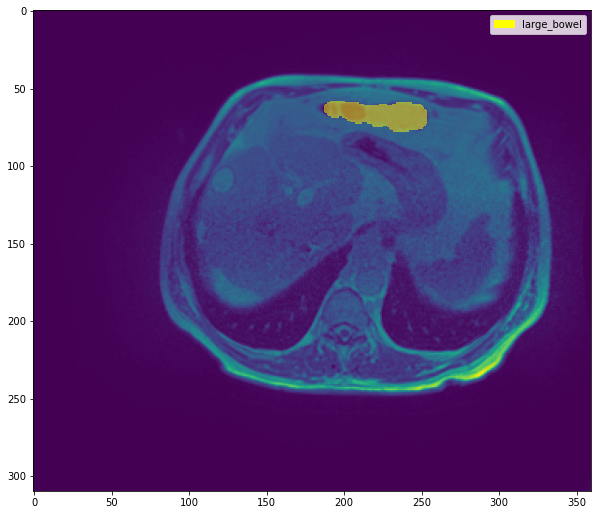

In [544]:
def show_scan_with_mask(train_csv_not_nan, img_number, data_path):
    segmentation = train_csv_not_nan.iloc[img_number]['segmentation']
#     img_id = train_csv_not_nan.iloc[img_number]['id']
#     img = plt.imread(generate_path_from_id(img_id, data_path))
#     shape_image = np.shape(img)
    shape_image = train_csv_not_nan.iloc[img_number]['shape']
    mask_segmentation = create_mask(segmentation, shape_image)
    plot_slice_with_mask(img_number, train_csv_not_nan, mask_segmentation)
    
show_scan_with_mask(train_csv_not_nan, 3000, params['data_path'])

In [ ]:
x_train = []
y_train = []
x_validation = []
y_validation = []